In [37]:
from qiskit.quantum_info import SparsePauliOp

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import GroverOptimizer
from qiskit_optimization import QuadraticProgram

from gurobi_optimods.qubo import solve_qubo

In [38]:
def convert_qubo_to_ising(qubo):
    # Number of qubits
    n = len(qubo)

    # Calculate the offset also, this is not important for the QAOA optimization
    offset = 0
    
    operator_list = []

    for i in range(n):
        for j in range(i, n):
            # Initialize the Pauli operator with all I's
            pauli_operator = list("I"*n)

            # Use only the upper triangular part of the matrix
            if j >= i:
                if i == j:
                    pauli_operator[i] = "Z"
                    ising_value = -(1/2)*np.sum(qubo[i])
                else:
                    pauli_operator[i] = "Z"
                    pauli_operator[j] = "Z"
                    ising_value = (1/2)*qubo[i][j]

                if not ising_value == 0:
                    ising_pauli_op = (''.join(pauli_operator), ising_value)
                    operator_list.append(ising_pauli_op)

                offset += (1/2)*qubo[i][j]

    operators = SparsePauliOp.from_list(operator_list)

    return operators, offset

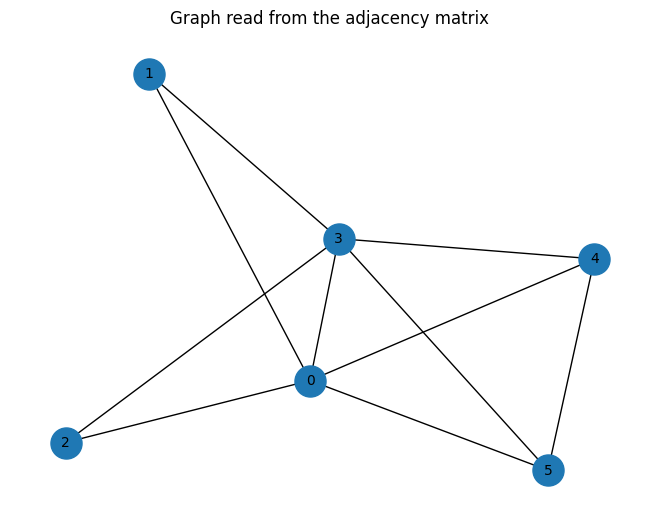

In [39]:
# Define MaxCut problem with an adjacency matrix and turn it into a QUBO matrix

adjacency_matrix = [[0, 1, 1, 1, 1, 1],
                    [1, 0, 0, 1, 0, 0],
                    [1, 0, 0, 1, 0, 0],
                    [1, 1, 1, 0, 1, 1],
                    [1, 0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 0, 1, 0, 0, 0, 0],
#                    [1, 0, 1, 1, 0, 0, 0, 0],
#                    [0, 1, 0, 0, 0, 0, 1, 0],
#                    [1, 1, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 1, 1, 0, 0, 0],
#                    [0, 0, 1, 0, 0, 0, 0, 1],
#                    [0, 0, 0, 0, 0, 0, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

graph = nx.Graph()
vertex_number = len(adjacency_matrix)
vertex_list = []
for i in range(vertex_number):
    vertex_list.append(i)
    for j in range(vertex_number):
        if adjacency_matrix[i][j] == 1:
            graph.add_edge(i, j)

num_nodes = graph.number_of_nodes()
Q = np.eye(num_nodes)

for i in range(len(adjacency_matrix[0])):
    sum = 0
    for j in range(len(adjacency_matrix[0])):
        sum = sum + adjacency_matrix[i][j]
        if adjacency_matrix[i][j] == 1 and not i == j:
            Q[i][j] = 1
    Q[i][i] = -sum

edge_list = list(graph.edges())
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10)
plt.title("Graph read from the adjacency matrix")
plt.show()

In [40]:
hamiltonian, offset = convert_qubo_to_ising(Q)

In [41]:
qp = QuadraticProgram()
qp.from_ising(hamiltonian, offset)

In [42]:
grover_optimizer = GroverOptimizer(len(Q), num_iterations=10, sampler=Sampler())
results = grover_optimizer.solve(qp)

In [43]:
print(results.prettyprint())

objective function value: -8.0
variable values: x0=0.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0
status: SUCCESS


In [44]:
# We must flip the order of the solution bits
solution = results.x[::-1]

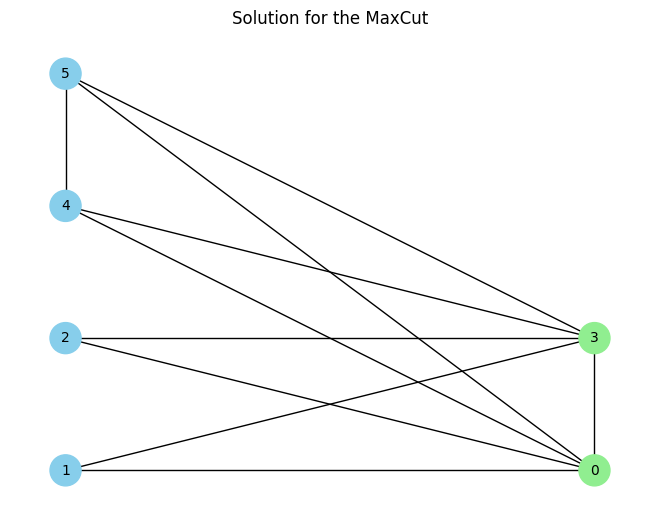

In [46]:
graph = nx.Graph()
group_1 = []
group_2 = []
vertex_number = len(solution)
for i in range(vertex_number):
    if solution[i] == 0:
        group_1.append(i)
    elif solution[i] == 1:
        group_2.append(i)
    else:
        print("No valid solution")
graph.add_nodes_from(group_1, bipartite=0)
graph.add_nodes_from(group_2, bipartite=1)
graph.add_edges_from(edge_list)
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(group_1))
pos.update((n, (2, i)) for i, n in enumerate(group_2))
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10, node_color=['skyblue'] * len(group_1) + ['lightgreen'] * len(group_2))
plt.title("Solution for the MaxCut")
plt.show()